# PZ-model

The above paragraph assumed an AP (all-pole) model. But we could also contemplate a PZ (pole-zero) model where the amplitudes *are* free parameters (equivalent to introducing zeros, but easier because we can get a better prior and we don't have to calculate the partial fraction expansion and we have nested models for $A_k=0$).

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

2022-11-22 23:17:46.967922: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]4.6s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]19.0s, 0.3min   : Loading run_nested...
[Memory]20.5s, 0.3min   : Loading run_nested...
[Memory]22.0s, 0.4min   : Loading run_nested...
[Memory]23.5s, 0.4min   : Loading run_nested...
[Memory]23.5s, 0.4min   : Loading get_aplawd_training_pairs...


[Memory]27.4s, 0.5min   : Loading get_vtrformants_training_data...
[Memory]34.6s, 0.6min   : Loading run_nested...
[Memory]35.5s, 0.6min   : Loading run_nested...
[Memory]36.4s, 0.6min   : Loading run_nested...
[Memory]37.3s, 0.6min   : Loading run_nested...
[Memory]37.3s, 0.6min   : Loading get_vtrformants_training_data...


## Check amplitude prior

von der Linden (2014) Eq. (21.67) p. 349

In [7]:
from vtr.prior import bandwidth
prior = bandwidth.TFB_prior()

[Memory]1173.0s, 19.6min: Loading get_vtrformants_training_data...
[Memory]1173.4s, 19.6min: Loading run_nested...
[Memory]1173.8s, 19.6min: Loading run_nested...


In [127]:
T, *xy = prior.sample(seed=jaxkey())
x, y = np.split(np.array(xy), 2)
x, y

(array([ 588.86684437, 1363.62701719, 2879.21954606]),
 array([ 42.66067359,  79.44726354, 300.92629481]))

In [128]:
def cos_overlap_matrix(x, y):
    x1, x2 = x[:,None], x[None,:]
    y1, y2 = y[:,None], y[None,:]
    
    num = (y1 + y2)*(x1**2 + x2**2 + (y1 + y2)**2)
    den = ((x1 - x2)**2 + (y1 + y2)**2)*((x1 + x2)**2 + (y1 + y2)**2)
    return num/den

def sin_overlap_matrix(x, y):
    x1, x2 = x[:,None], x[None,:]
    y1, y2 = y[:,None], y[None,:]
    
    num = 2*x1*x2*(y1 + y2)
    den = ((x1 - x2)**2 + (y1 + y2)**2)*((x1 + x2)**2 + (y1 + y2)**2)
    return num/den

def cos_sin_overlap_matrix(x, y):
    x1, x2 = x[:,None], x[None,:]
    y1, y2 = y[:,None], y[None,:]
    
    num = x2 *(-x1**2 + x2**2 + (y1 + y2)**2)
    den = (x1**2 - x2**2)**2 + 2*(x1**2 + x2**2)*(y1 + y2)**2 + (y1 + y2)**4
    return num/den
    
def overlap_matrix(x, y):
    X = 2*np.pi*x
    Y = np.pi*y
    
    c = cos_overlap_matrix(X, Y)
    s = sin_overlap_matrix(X, Y)
    cs = cos_sin_overlap_matrix(X, Y)
    
    S = np.block([
        [c,    cs],
        [cs.T, s ]
    ])
    return S

K = len(x)
E = 2*K
S = overlap_matrix(x, y)
Sigma = (1/E)*inv(S)

In [129]:
a = np.random.multivariate_normal(zeros(E), Sigma)
a

array([ 5.64319497e+00,  5.11967105e+00,  1.19394679e-02,  1.50352009e+01,
       -1.74658078e+01,  6.70740867e+00])

0.7978633029621053

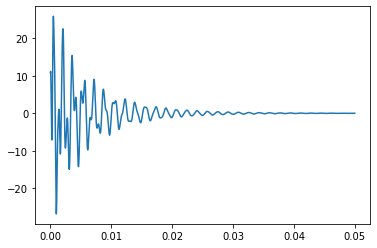

In [130]:
def eval_G(t, x, y):
    K = len(x)
    G = np.empty((len(t), 2*K))
    X, Y, T = x[None,:], y[None,:], t[:,None]
    
    G[:, :K] = np.cos(2.*np.pi*X*T)*np.exp(-np.pi*Y*T)
    G[:, K:] = np.sin(2.*np.pi*X*T)*np.exp(-np.pi*Y*T)
    return G # (N, m)

t, dt = np.linspace(0., .05, 100000, retstep=True) # sec
G = eval_G(t, x, y)
s = G @ a
plot(t, s)
mu2 = np.dot(s, s)*dt
mu2

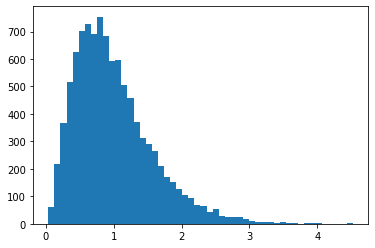

In [131]:
mu2s = []
for _ in range(10000):
    a = np.random.multivariate_normal(zeros(E), Sigma)
    s = G @ a
    mu2 = np.dot(s, s)*dt
    mu2s += [mu2]

hist(mu2s, bins=50);

In [132]:
mean(mu2s)

0.9972163401911471

## Check power spectrum

Still need to test with LTI implementation (need the zeros for that).

-0.38061377173193844

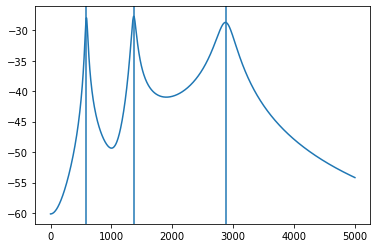

In [197]:
def power_spectrum_dB(f, a, x, y):
    """Calculate the power spectrum of the impulse response in dB
    
    The impulse response is a sum of decaying sinusoids which are
    parametrized by the amplitudes `A` and bandwidths `y` and
    frequencies `x`. This function computes the analytical
    magnitude spectrum of that sum and evaluates it at `freqs`. The
    Fourier transform used is the same as (Eq. 1) in the [Wiki page][1].
    For an illustration on a simpler example, see ./FFT_scaling.ipynb.
    
    We calculate this in dB because Gaussian statistics are more meaningful
    in this domain (for example, the power will always be positive.)

        [1]: https://en.wikipedia.org/wiki/Fourier_transform
    """
    A = a[:,None]
    X = x[:,None]
    Y = y[:,None]
    s = (2*np.pi*1j)*f[None,:]
    
    Acos, Asin = np.split(A, 2)
    
    # Calculate analytical Fourier transform
    num = (np.pi*Y + s)*Acos + 2*np.pi*X*Asin
    den = (np.pi*Y + s)**2 + (2*np.pi*X)**2
    transform = np.sum(num/den, axis=0) # Sum over (bandwidth, frequency) pairs
    power_dB = 20*np.log10(np.abs(transform))
    return power_dB

a = np.random.multivariate_normal(zeros(E), Sigma)
f = np.linspace(0, 5000., 1000)
power = power_spectrum_dB(f, a, x, y)
plot(f, power)
for xi in x: axvline(xi)
spectrum.fit_tilt(f, power)

-5.087215147795832

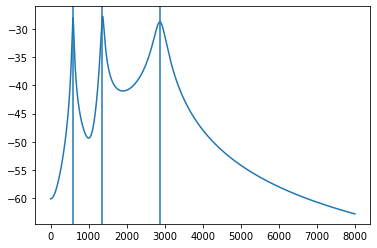

In [198]:
f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)
power = power_spectrum_dB(f, a, x, y)
plot(f, power)
for xi in x: axvline(xi)
spectrum.fit_tilt(f, power)